# Chatbot with Profile Schema
- We saved the memory as a string
- It is beneficial if the memory has some form of structure

## Goals
- Create a chatbot with both `within-`thread and `cross-thread` memory saving semantic memory **"in the hotpath"**

In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

## Defining a User Profile Schema
- For structured data, we can use Pydantic, TypedDict, JSON etc.

In [8]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    username: str
    interests: List[str]

### Saving a Schema to the Store

In [3]:
# Create an instance of UserProfile
user_1 = UserProfile(username="Manan", interests=["Reading","Coding"])
user_1

{'username': 'Manan', 'interests': ['Reading', 'Coding']}

In [4]:
# Saving the UserProfile as the value in the store 
from uuid import uuid4
from langgraph.store.memory import InMemoryStore

# Initalize the memory store
in_memory_store = InMemoryStore()

# Namespace
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Key-Value pair
key = str(uuid4())
value = user_1

in_memory_store.put(namespace_for_memory,key,value)
memory = in_memory_store.search(namespace_for_memory)
memory[0].dict()

{'namespace': ['1', 'memory'],
 'key': 'a0bd8346-412e-4727-98c5-1cae8b3246c3',
 'value': {'username': 'Manan', 'interests': ['Reading', 'Coding']},
 'created_at': '2025-06-29T18:39:26.466977+00:00',
 'updated_at': '2025-06-29T18:39:26.466977+00:00',
 'score': None}

## Chatbot with Profile Schema
- We have now defined the structure of the memory for a User
- Now, using with_structured_output, we can get the strucred response from the llm

In [5]:
model = ChatOpenAI(model="gpt-4o",temperature=0)
structured_model = model.with_structured_output(UserProfile)
structured_model.invoke("My name is Manan. I like to Read Books!")

{'username': 'Manan', 'interests': ['Reading Books']}

In [9]:
# Let's modify our chatbot
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore, BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

## Write the prompts
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

# node 1 - The Chatbot
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Get the memory
    user_id = config['configurable']['user_id']
    namespace = ('memory',user_id)
    key = 'user_memory'

    existing_memory = store.get(namespace,key)
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('username','Unknown')}\n"
            f"Interests: {''.join(memory_dict.get('interests',[]))}"
        )
    else:
        formatted_memory = None
    
    # Modify the system prompt
    system_message = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    # Get the response
    return {'messages':model.invoke([SystemMessage(content=system_message)] + state['messages'])}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = structured_model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

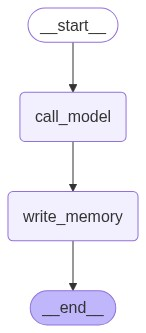

In [10]:
# Define the graph
from IPython.display import display, Image
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Sample Run

In [17]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Manan and I like to Read Books and Code.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Manan and I like to Read Books and Code.
================================== Ai Message ==================================

Hi Manan! It's great to meet you. Reading books and coding are both fantastic hobbies. Do you have any favorite books or programming languages you enjoy working with?


In [20]:
# Check the within-thread memory
thread = {'configurable':{'thread_id':"1"}}
state = graph.get_state(thread)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Manan and I like to Read Books and Code.
================================== Ai Message ==================================

Hi Manan! It's great to meet you. Reading books and coding are both fantastic hobbies. Do you have any favorite books or programming languages you enjoy working with?


In [22]:
# Check the cross-thread memory
namespace = ('memory', "1")
key = 'user_memory'
memory = across_thread_memory.get(namespace,key)
memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'username': 'Manan', 'interests': ['Reading Books', 'Coding']},
 'created_at': '2025-06-28T17:08:41.320754+00:00',
 'updated_at': '2025-06-28T17:08:41.320754+00:00'}

In [23]:
# User input 2
input_messages = [HumanMessage(content="My full name is Manan Parakh. I like to play Cricket as well!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My full name is Manan Parakh. I like to play Cricket as well!
================================== Ai Message ==================================

Nice to meet you, Manan Parakh! It's great to hear that you enjoy playing cricket along with reading and coding. Do you have a favorite cricket player or team? And are there any particular genres of books or coding projects you're currently interested in?


In [24]:
# Check the within-thread memory
thread = {'configurable':{'thread_id':"1"}}
state = graph.get_state(thread)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Manan and I like to Read Books and Code.
================================== Ai Message ==================================

Hi Manan! It's great to meet you. Reading books and coding are both fantastic hobbies. Do you have any favorite books or programming languages you enjoy working with?
================================ Human Message =================================

My full name is Manan Parakh. I like to play Cricket as well!
================================== Ai Message ==================================

Nice to meet you, Manan Parakh! It's great to hear that you enjoy playing cricket along with reading and coding. Do you have a favorite cricket player or team? And are there any particular genres of books or coding projects you're currently interested in?


In [25]:
# Check the cross-thread memory
namespace = ('memory', "1")
key = 'user_memory'
memory = across_thread_memory.get(namespace,key)
memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'username': 'Manan Parakh',
  'interests': ['Reading Books', 'Coding', 'Cricket']},
 'created_at': '2025-06-28T17:11:53.118488+00:00',
 'updated_at': '2025-06-28T17:11:53.118488+00:00'}

## Complex Schemas: `with_structured_output` Fails!

In [57]:
from typing import List, Optional
from pydantic import BaseModel, Field

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [58]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

1 validation error for TelegramAndTrustFallPreferences
pertinent_user_preferences.communication_preferences.semaphore
  Input should be a valid dictionary or instance of Semaphore [type=model_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type


## TrustCall for Creating and Updating Profile Schemas

In [21]:
print("LangSmith tracing is", "on" if os.environ.get("LANGSMITH_TRACING", "").lower() == "true" else "off")


LangSmith tracing is off


In [25]:
# Mock Conversation
from langchain_core.messages import AIMessage
conversation = [HumanMessage(content="Hi, I'm Manan."), 
                AIMessage(content="Nice to meet you, Manan."), 
                HumanMessage(content="I really like to read books and coding.")]

- We use `create_extractor`, passing in the model as well as our schema as a tool
- Schema could be a JSON Object, Python Dict or Pydantic Model
- Under the hood, `trustcall` uses tool_calling to produce **structured_outputs** from an **input list of messages**
- To force trustcall to produce structured output, we can include the schema name in the `tool_choice` argument

In [46]:
from trustcall import create_extractor
from pydantic import BaseModel, Field

# Define the Schema
class UserProfile(BaseModel):
    """UserProfile Schema with Typed fields"""
    user_name: str = Field(description= "The user's preffered name")
    interests: List[str] = Field(description="A list of User's Interests")

# Create the extractor
trustcall_extractor = create_extractor(model, 
                                       tools = [UserProfile],
                                       tool_choice="UserProfile")
# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
from langchain_core.tracers.context import tracing_v2_enabled

result = trustcall_extractor.invoke([SystemMessage(content=system_msg)] + conversation)
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zRaIyQqt2lKZr9DfJU5EJS4v', 'function': {'arguments': '{"user_name":"Manan","interests":["reading books","coding"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 133, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'finish_reason': 'stop', 'logprobs': None}, id='run-2030f4e2-bba1-4b54-92dd-dec3fb87727b-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Manan', 'interests': ['reading books', 'coding']}, 'id': 'call_zRaIyQqt2lKZr9DfJU5EJS4v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 16, 'total_tokens': 149})],
 'resp

In [47]:
# The toolcalls it made
result['messages'][0].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_zRaIyQqt2lKZr9DfJU5EJS4v)
 Call ID: call_zRaIyQqt2lKZr9DfJU5EJS4v
  Args:
    user_name: Manan
    interests: ['reading books', 'coding']


In [50]:
schema = result['responses']
schema, type(schema)

([UserProfile(user_name='Manan', interests=['reading books', 'coding'])], list)

In [49]:
# Into a dict
schema[0].model_dump()

{'user_name': 'Manan', 'interests': ['reading books', 'coding']}

### Updating an Existing Schema using TrustCall
- It will take a set of conversation and existing schema
- JSON patch: Will generate only the updates to be made
- Benefits: Less prone to errors, more efficient as the number of tokens is minimized

* We can save the existing schema as a dict
* We can use `model_dump` to serialize a Pydantic model instance into a dict
* We can pass it to 'existing' argument along with the schema name, `UserProfile`

In [51]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Manan."), 
                        AIMessage(content="Nice to meet you, Manan."), 
                        HumanMessage(content="I really like to read books and coding."),
                        AIMessage(content="Great! Which language do you like the most?"),
                        HumanMessage(content="I love Python!"),]

# Updated instructions
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoking the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation},
                                    {'existing':{"UserProfile": schema[0].model_dump()}})
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NTYWKESVaFIzjzVjlwAgacpp', 'function': {'arguments': '{"user_name":"Manan","interests":["reading books","coding","Python"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 162, 'total_tokens': 180, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run-ffd584f1-437a-4ea4-8f4f-e9abf471f63c-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Manan', 'interests': ['reading books', 'coding', 'Python']}, 'id': 'call_NTYWKESVaFIzjzVjlwAgacpp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 18, 'total_toke

In [52]:
result['messages'][0].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_NTYWKESVaFIzjzVjlwAgacpp)
 Call ID: call_NTYWKESVaFIzjzVjlwAgacpp
  Args:
    user_name: Manan
    interests: ['reading books', 'coding', 'Python']


In [53]:
result['responses']

[UserProfile(user_name='Manan', interests=['reading books', 'coding', 'Python'])]

In [55]:
result['response_metadata']

[{'id': 'call_NTYWKESVaFIzjzVjlwAgacpp'}]

### Testing with Challenging Schema 

In [60]:
from langchain_core.messages import AIMessage, HumanMessage

# Add model_copy method for compatibility
AIMessage.model_copy = lambda self, deep=False: self.copy()
HumanMessage.model_copy = lambda self, deep=False: self.copy()

bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='standard encoding', sentence_preference_revealed='standard encoding')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Daredevil')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='straight key')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='higher')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='diamond formation')])))

In [61]:
result['responses'][0].model_dump()

{'pertinent_user_preferences': {'communication_preferences': {'telegram': {'preferred_encoding': [{'preference': 'standard encoding',
      'sentence_preference_revealed': 'standard encoding'}],
    'favorite_telegram_operators': None,
    'preferred_telegram_paper': [{'preference': 'Daredevil',
      'sentence_preference_revealed': 'Daredevil'}]},
   'morse_code': {'preferred_key_type': [{'preference': 'straight key',
      'sentence_preference_revealed': 'straight key'}],
    'favorite_morse_abbreviations': None},
   'semaphore': {'preferred_flag_color': None, 'semaphore_skill_level': None}},
  'trust_fall_preferences': {'preferred_fall_height': [{'preference': 'higher',
     'sentence_preference_revealed': 'higher'}],
   'trust_level': None,
   'preferred_catching_technique': [{'preference': 'diamond formation',
     'sentence_preference_revealed': 'diamond formation'}]}}}

## Chatbot with Profile Schema Updating

Memory Structure to be Used:

namespace = (user_id, 'memory')

key = 'user_memory'

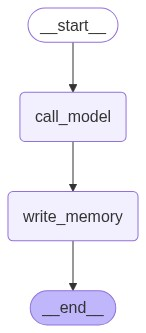

In [68]:
# Let's write the whole chatbot on our own
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.store.memory import InMemoryStore, BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

from pydantic import BaseModel, Field
from typing import List

from trustcall import create_extractor

# Create the Custom User Profile to be used
class UserProfile(BaseModel):
    user_name: str = Field(description="User's preffered name.")
    user_location: str = Field(description="Location of the User.")
    interests: List[str] = Field(description="A list of User's interests")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(model,
                                       tools= [UserProfile],
                                       tool_choice="UserProfile")

# Define the first node: A chatbot chatting while keeping user's history in mind
CHAT_PROMPT = """You are a helpful assisstant. Respond to the user's query while keeping memory about the user in mind.
memory (It could be empty as well): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Calls the model and talks to the user based on memory"""
    # Get the user's memory from the store
    user_id = config['configurable']['user_id']
    namespace = (user_id, 'memory')
    key = 'user_memory'

    existing_memory = store.get(namespace,key)

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None
    
    # Format the system prompt
    system_message = CHAT_PROMPT.format(memory = formatted_memory)

    return {'messages':model.invoke([SystemMessage(content = system_message)] + state['messages'])}

# Define the Second Node to update the memory
TRUSTCALL_INSTRUCTION = """ 
Based on the given conversation, create or update the given memory (JSON doc)"""

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Get the user's memory from the store
    user_id = config['configurable']['user_id']
    namespace = (user_id, 'memory')
    key = 'user_memory'

    existing_memory = store.get(namespace, key)

    if existing_memory is not None and getattr(existing_memory, "value", None) is not None:
        existing_profile = {'UserProfile': existing_memory.value}
    else:
        existing_profile = None

    # Invoke the extractor
    result = trustcall_extractor.invoke({
        "messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"],
        'existing': existing_profile
    })
    # Get the updated profile as a JSON object
    updated_profile = result['responses'][0].model_dump()
    # Update the memory
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Sample Run

In [69]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Manan")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Manan
================================== Ai Message ==================================

Hello, Manan! How can I assist you today?


In [72]:
# Check the checkpointer
thread = {'configurable':{'thread_id':"1"}}
state = graph.get_state(thread)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Manan
================================== Ai Message ==================================

Hello, Manan! How can I assist you today?


In [74]:
# Check the store
user_id = "1"
namespace = (user_id, 'memory')
key = "user_memory"

memory = across_thread_memory.get(namespace,key)
memory.dict()

{'namespace': ['1', 'memory'],
 'key': 'user_memory',
 'value': {'user_name': 'Manan', 'user_location': '', 'interests': []},
 'created_at': '2025-06-29T20:02:09.501000+00:00',
 'updated_at': '2025-06-29T20:02:09.501000+00:00'}

In [75]:
# User input 
input_messages = [HumanMessage(content="I live in India. I love to read books and code!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I live in India. I love to read books and code!
================================== Ai Message ==================================

That's great, Manan! India has such a rich literary culture, and it's fantastic that you enjoy reading. Coding is a wonderful skill to have as well. Do you have any favorite books or programming languages you like to work with?


In [76]:
# Check the checkpointer
thread = {'configurable':{'thread_id':"1"}}
state = graph.get_state(thread)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Manan
================================== Ai Message ==================================

Hello, Manan! How can I assist you today?
================================ Human Message =================================

I live in India. I love to read books and code!
================================== Ai Message ==================================

That's great, Manan! India has such a rich literary culture, and it's fantastic that you enjoy reading. Coding is a wonderful skill to have as well. Do you have any favorite books or programming languages you like to work with?


In [77]:
# Check the store
user_id = "1"
namespace = (user_id, 'memory')
key = "user_memory"

memory = across_thread_memory.get(namespace,key)
memory.dict()

{'namespace': ['1', 'memory'],
 'key': 'user_memory',
 'value': {'user_name': 'Manan',
  'user_location': 'India',
  'interests': ['reading books', 'coding']},
 'created_at': '2025-06-29T20:05:02.931368+00:00',
 'updated_at': '2025-06-29T20:05:02.931368+00:00'}